## Ingeniería de Features

A continuación, trabajaremos directamente sobre el dataset `Car details v3.csv`, elegido previamente por la cantidad de observaciones y features disponibles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import re

In [2]:
car_details_v3 = pd.read_csv('../datasets/Car details v3.csv')

Eliminamos los duplicados:

In [3]:
car_details_v3 = car_details_v3.drop_duplicates()

Vamos a proceder primero a convertir a numéricas las variables `engine`, `mileage` y `max_power`. Para eso, analizaremos posibles inconsistencias en unidades:

In [4]:
not_null_no_cc = car_details_v3[(car_details_v3['engine'].notnull()) & ~np.array(car_details_v3['engine'].str.contains('CC', case=False), dtype=bool)]

print("Número de observaciones con valor en 'engine' pero con unidades distintas a 'CC':", not_null_no_cc.shape[0])

Número de observaciones con valor en 'engine' pero con unidades distintas a 'CC': 0


Al no tener valores con otras unidades, procedemos a convertir a numérico:

In [5]:
engine_non_null = car_details_v3[car_details_v3['engine'].notnull()].copy()
car_details_v3['engine_cc'] = engine_non_null['engine'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['engine_cc'] = pd.to_numeric(car_details_v3['engine_cc'], errors='coerce')

In [6]:
not_null_no_bhp = car_details_v3[(car_details_v3['max_power'].notnull()) & ~np.array(car_details_v3['max_power'].str.contains('bhp', case=False), dtype=bool)]

print("Número de observaciones con valor en 'max_power' pero con unidades distintas a 'bhp':", not_null_no_bhp.shape[0])

Número de observaciones con valor en 'max_power' pero con unidades distintas a 'bhp': 3


In [7]:
not_null_no_bhp['max_power']

575     0
1442    0
2549    0
Name: max_power, dtype: object

En todos los casos el valor es 0, lo cual puede interpretarse como dato faltante. Por lo tanto, podemos pasarlos a null y convertir el resto en numérico (luego trataremos los datos faltantes).

In [8]:
car_details_v3['max_power'] = car_details_v3['max_power'].replace('0', np.nan)

max_power_non_null = car_details_v3[car_details_v3['max_power'].notnull()].copy()
car_details_v3['max_power_bhp'] = max_power_non_null['max_power'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['max_power_bhp'] = pd.to_numeric(car_details_v3['max_power_bhp'], errors='coerce')

Como mencionamos, con `mileage` no basta con quitar las unidades, puesto que el rendimiento está expresado en kmpl o km/kg según el tipo de combustible. Lo que podemos utilizar es la densidad del combustible para dejar todos los valores en kmpl:

In [9]:
def convert_to_kmpl(row):
    kmpl_rx = r"(\d*\.?\d+)\s*(kmpl)"
    kmkg_rx = r"(\d*\.?\d+)\s*(km/kg)"

    conversion_factor = 1.39

    mileage_value = None

    # Si el fuel es Diesel o Petrol y tiene kmpl, simplemente extraemos el número
    if row['fuel'].lower() in ['diesel', 'petrol']:
        match = re.search(kmpl_rx, row['mileage'])
        if match:
            mileage_value = float(match.group(1))

    # Si el fuel es CNG o LPG y tiene km/kg, convertimos a kmpl
    elif row['fuel'].lower() in ['cng', 'lpg']:
        match = re.search(kmkg_rx, row['mileage'])
        if match:
            kmkg_value = float(match.group(1))
            mileage_value = kmkg_value * conversion_factor  # Convertimos a kmpl

    return mileage_value

mileage_non_null = car_details_v3[car_details_v3['mileage'].notnull()].copy()
car_details_v3['mileage_kmpl'] = mileage_non_null.apply(convert_to_kmpl, axis=1)

Finalmente, queremos poder trabajar con la columna torque, sabiendo que está compuesta de dos valores numéricos (uno que puede ser en realidad un rango) que nos brindan información de la potencia y la versatilidad del vehículo, que puede ser importante en la predicción del precio.

Lo primero que podemos hacer es decidir separar esta feature en dos, la fuerza de giro (medida en nm o kgm) y la velocidad a la que se alcanza ese torque (medida en rpm).

Por otro lado, al contar en algunos casos con el pico y en otros casos con un rango, decidimos quedarnos en todos los casos con un valor puntual, y para los casos en que contamos con rango, lo más adecuado es tomar el valor superior del mismo. Esto puede ser controversial, dado que conocer el rango es a su vez un dato valioso, puesto que nos da información de cualidades técnicas del motor y de cierta versatilidad para el manejo del vehículo, pero la imposibilidad de completar los rangos para las observaciones faltantes nos decantan a decidir trabajar con el pico.

Finalmente, para el torque haremos una conversión de unidades tal como hicimos con `mileage`.

En este caso, la variabilidad con la que vienen expresados los valores implican un trabajo exhaustivo con el uso de expresiones regulares, como veremos a continuación:

In [10]:
# Contar valores nulos y ceros en la columna 'torque'
missing_torque = car_details_v3['torque'].isnull().sum()
zero_torque = (car_details_v3['torque'] == 0).sum()

# Total de valores en la columna
total_values = car_details_v3['torque'].shape[0]

print(f"Número de valores faltantes (missing) en 'torque': {missing_torque}")
print(f"Número de ceros en 'torque': {zero_torque}")
print(f"Total de valores en 'torque': {total_values}")
print(f"Porcentaje de valores faltantes: {missing_torque / total_values * 100:.2f}%")

Número de valores faltantes (missing) en 'torque': 209
Número de ceros en 'torque': 0
Total de valores en 'torque': 6926
Porcentaje de valores faltantes: 3.02%


In [11]:
def standardize_torque(torque_str):
    if pd.isna(torque_str):
        return {'torque_peak_power': np.nan, 'torque_peak_speed': np.nan}

    # Regex patterns for different torque formats
    patterns = [
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*@\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*at\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*@\s*([-\d\s,]+)\s*\(kgm@\s*rpm\)",
        r"(\d*\.?\d+)\s*kgm\s*at\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*\((\d*\.?\d+)\s*kgm\)\s*@\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*\((\d*\.?\d+)\)\s*@\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*/\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*/\s*([-\d\s,]+)",
        r"(\d*\.?\d+)\s*(kgm|nm)?\s*\((\d*\.?\d+)\s*(kgm)?\)\s*@\s*([-\d\s,]+)\s*(rpm)?",
        r"(\d*\.?\d+)\s*(kgm|nm)?"
    ]

    # Initialize default values
    torque_peak_power = None
    torque_peak_speed = None

    for pattern in patterns:
        match = re.findall(pattern, torque_str.lower())
        if match:
            if len(match[0]) >= 3:  # Check if there are enough groups
                value = match[0][0]
                unit = match[0][1] if len(match[0]) > 1 else None
                rpm_range = match[0][-2] if len(match[0]) > 2 else None

                # Convert value to float
                value = float(value)

                # Convert kgm to Nm if necessary
                if 'kgm' in torque_str.lower() or (unit and 'kgm' in unit):
                    value *= 9.81  # Convert kgm to Nm

                # Store torque value
                torque_peak_power = value

                # Extract maximum RPM from range if available
                if rpm_range:
                    rpm_range = rpm_range.replace(',', '')  # Remove commas from the RPM range
                    if '-' in rpm_range:
                        rpm_values = list(map(int, rpm_range.split('-')))
                        torque_peak_speed = max(rpm_values)  # Take the max RPM from the range
                    else:
                        torque_peak_speed = int(rpm_range.strip())  # Single RPM value
            break  # Stop after the first match   

    # Return the results as a dictionary
    return {'torque_peak_power': torque_peak_power, 'torque_peak_speed': torque_peak_speed}

In [12]:
torque_results = car_details_v3['torque'].apply(standardize_torque)

car_details_v3['torque_peak_power'] = torque_results.apply(lambda x: x['torque_peak_power'])
car_details_v3['torque_peak_speed'] = torque_results.apply(lambda x: x['torque_peak_speed'])

Veamos las distribuciones de los valores de las nuevas variables numéricas:

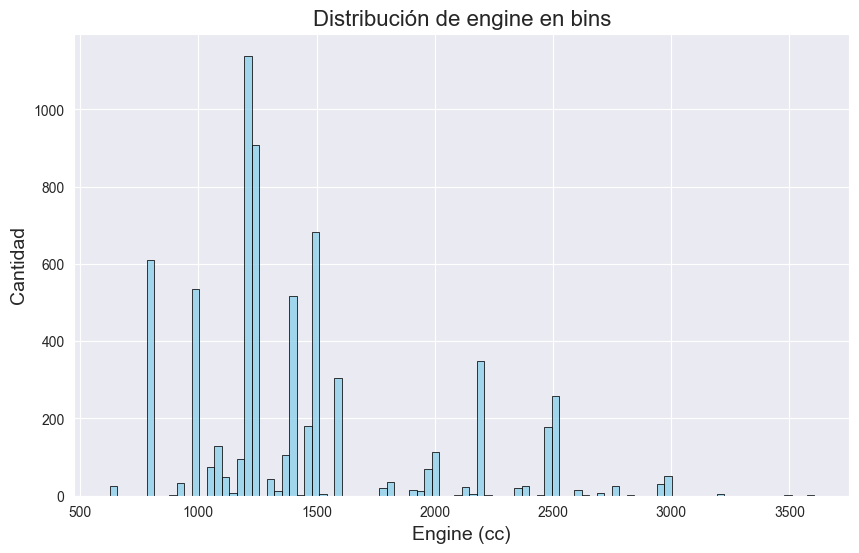

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(car_details_v3['engine_cc'].dropna(), bins=np.histogram_bin_edges(car_details_v3['engine_cc'].dropna(), bins='auto'), kde=False, color='skyblue', edgecolor='black')

plt.title('Distribución de engine en bins', fontsize=16)
plt.xlabel('Engine (cc)', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.show()

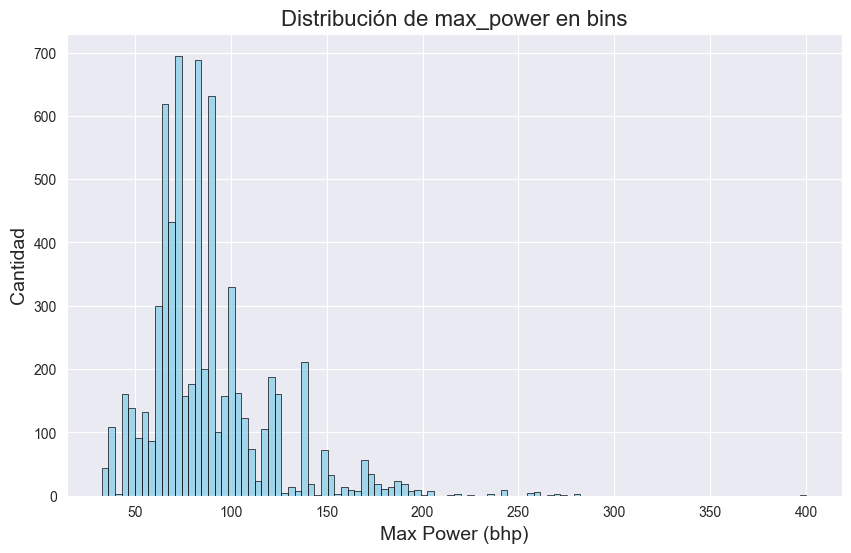

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(car_details_v3['max_power_bhp'].dropna(), bins=np.histogram_bin_edges(car_details_v3['max_power_bhp'].dropna(), bins='auto'), kde=False, color='skyblue', edgecolor='black')

plt.title('Distribución de max_power en bins', fontsize=16)
plt.xlabel('Max Power (bhp)', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.show()

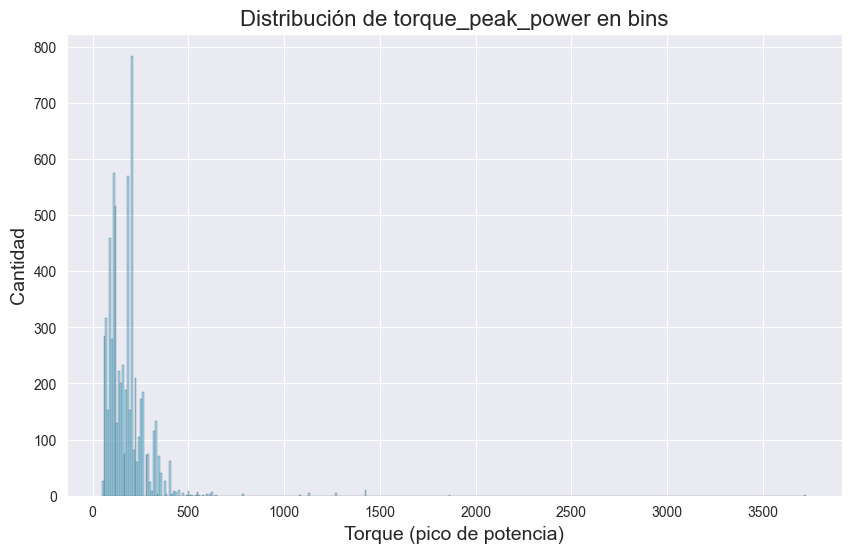

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(car_details_v3['torque_peak_power'].dropna(), bins=np.histogram_bin_edges(car_details_v3['torque_peak_power'].dropna(), bins='auto'), kde=False, color='skyblue', edgecolor='black')

plt.title('Distribución de torque_peak_power en bins', fontsize=16)
plt.xlabel('Torque (pico de potencia)', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.show()

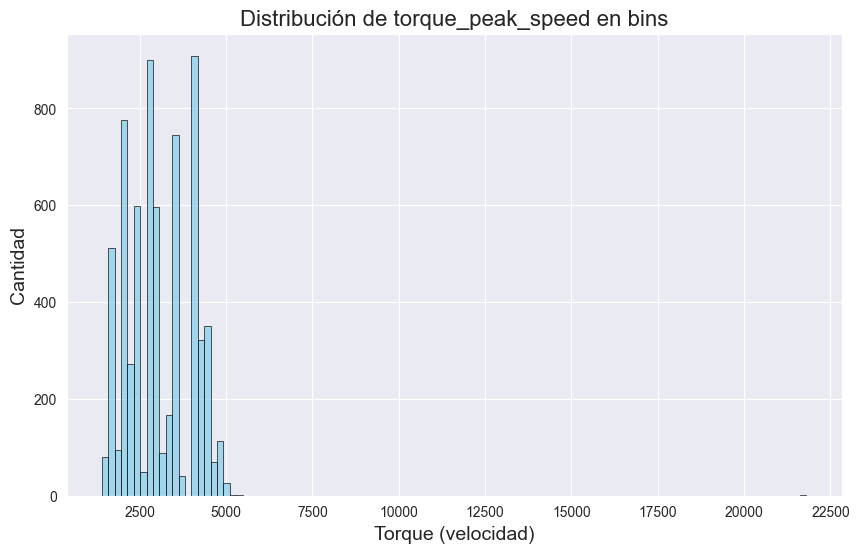

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(car_details_v3['torque_peak_speed'].dropna(), bins=np.histogram_bin_edges(car_details_v3['torque_peak_speed'].dropna(), bins='auto'), kde=False, color='skyblue', edgecolor='black')

plt.title('Distribución de torque_peak_speed en bins', fontsize=16)
plt.xlabel('Torque (velocidad)', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.show()

Observamos algunos outliers que se alejan de la distribución del valor. 

Finalmente, analizando la columna `name` podemos identificar que siempre empieza con la marca del modelo, seguida del modelo en sí. Esto nos permite crear 2 features a partir de esta, por caso en que la marca de forma aislada brinde información al modelo para la predicción del precio: 

Veamos la cantidad de observaciones por marca:

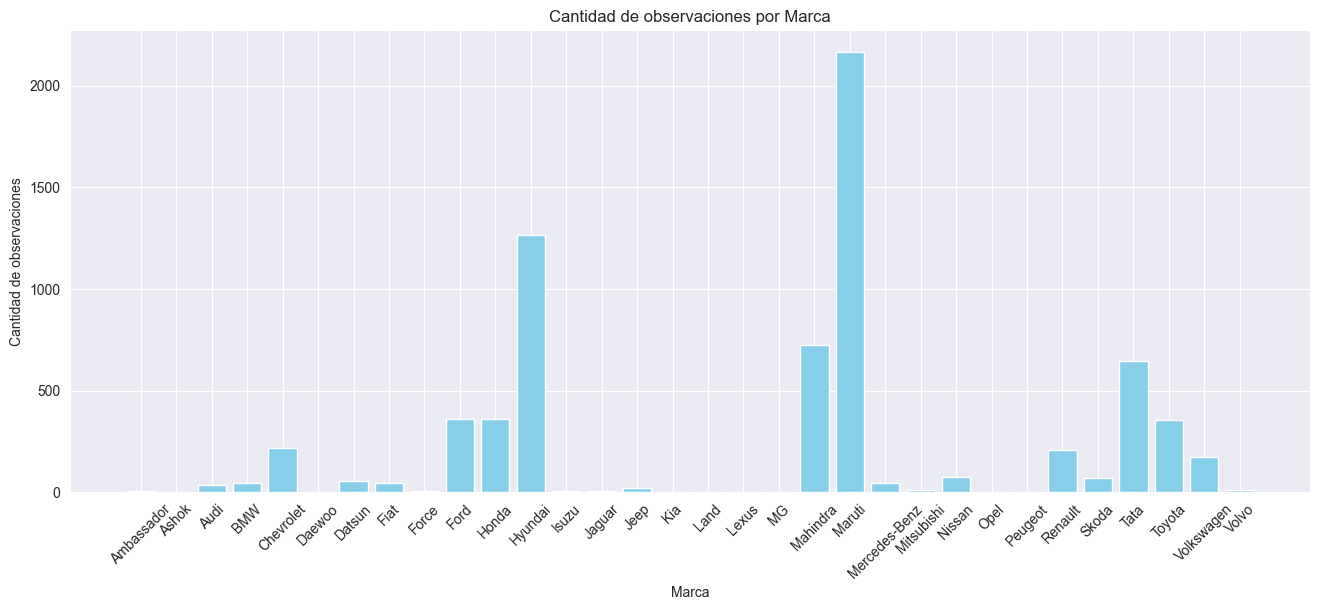

In [17]:
car_details_v3[['make', 'model']] = car_details_v3['name'].str.split(' ', n=1, expand=True)
make_counts = car_details_v3['make'].value_counts().sort_index()

plt.figure(figsize=(16, 6))
plt.bar(make_counts.index, make_counts.values, color='skyblue')
plt.xlabel('Marca')
plt.ylabel('Cantidad de observaciones')
plt.title('Cantidad de observaciones por Marca')
plt.xticks(rotation=45)
plt.show()

Tal como fue propuesto, vamos a definir un orden para la feature `owner`, asumiendo que existe no solo un orden lógico entre la cantidad de dueños, sino que además consideraremos "Test Drive Car" por "debajo" de "Fourth & Above Owner":

In [18]:
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}

car_details_v3['owner'] = car_details_v3['owner'].map(owner_mapping)

Para las variables categóricas, dado que la cardinalidad es baja (con excepción de model), vamos a utilizar One Hot Encoding: 

In [19]:
categorical_cols = ['fuel', 'seller_type', 'transmission', 'make']

encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical columns
encoded_columns = encoder.fit_transform(car_details_v3[categorical_cols])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df.index = car_details_v3.index
car_details_v3 = pd.concat([car_details_v3, encoded_df], axis=1)

Eliminemos las columnas que ya no vamos a utilizar:

In [20]:
car_details_v3 = car_details_v3.drop(columns=['name', 'mileage', 'engine', 'max_power', 'torque', 'fuel', 'seller_type', 'transmission'])

Revisemos datos faltantes:

In [21]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: owner - Missing values: 0
Feature: seats - Missing values: 208
Feature: engine_cc - Missing values: 208
Feature: max_power_bhp - Missing values: 209
Feature: mileage_kmpl - Missing values: 208
Feature: torque_peak_power - Missing values: 213
Feature: torque_peak_speed - Missing values: 213
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: fuel_Diesel - Missing values: 0
Feature: fuel_LPG - Missing values: 0
Feature: fuel_Petrol - Missing values: 0
Feature: seller_type_Individual - Missing values: 0
Feature: seller_type_Trustmark Dealer - Missing values: 0
Feature: transmission_Manual - Missing values: 0
Feature: make_Ashok - Missing values: 0
Feature: make_Audi - Missing values: 0
Feature: make_BMW - Missing values: 0
Feature: make_Chevrolet - Missing values: 0
Feature: make_Daewoo - Missing values: 0
Feature: make_Datsun - Missing val

Antes de proceder con el tratamiento de faltantes, vamos a proceder ahora si a graficar la matriz de correlación, contando ahora con varias features numéricas: 

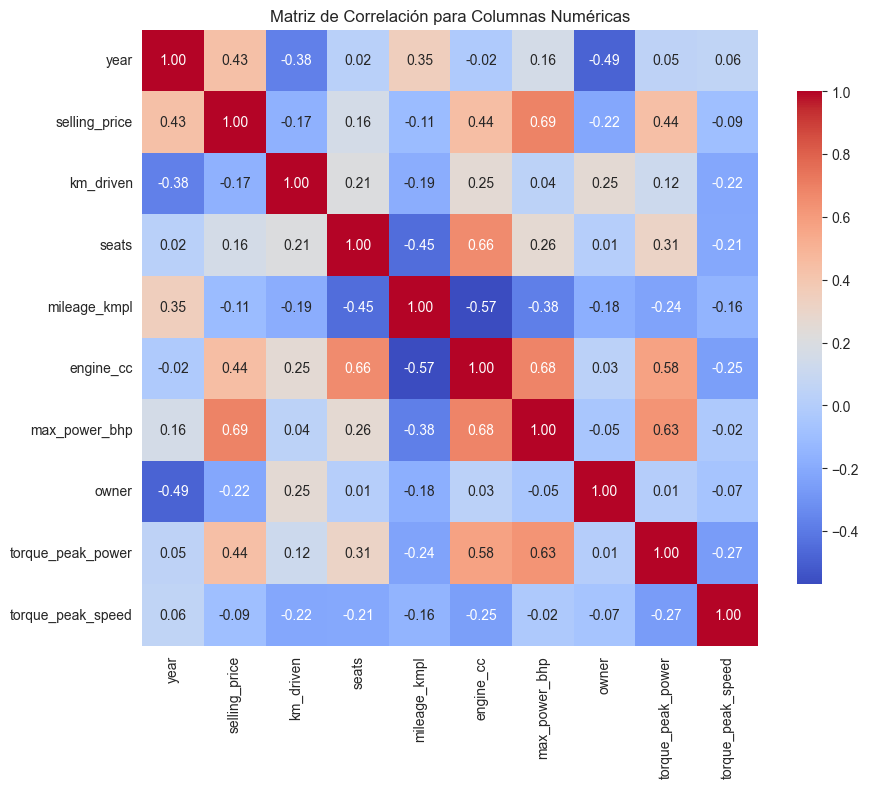

In [22]:
numerical_data = car_details_v3[['year', 'selling_price', 'km_driven', 'seats', 'mileage_kmpl', 'engine_cc', 'max_power_bhp', 'owner', 'torque_peak_power', 'torque_peak_speed']]

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Matriz de Correlación para Columnas Numéricas')

plt.show()

Los datos arrojados por la matriz resultan los esperables. Para el precio de venta, vemos una correlación lineal positiva con la potencia del motor, y luego en menor medida con la fuera de giro y la cilindrada del mismo, todos datos que suelen guardar cierta relación.

Además, para años más actuales el precio tiende a subir, pero baja para mayor kilometraje o mayor cantidad de dueños. Estas 3 variables a su vez están relacionadas. Es de suponer que un auto más antiguo tenga más kilómetros y una mayor cantidad de dueños.

Finalmente, otros datos esperables a mencionar: a mayor cantidad de asientos, peor rendimiento del combustible, y mayor cilindrada (motor más grande requerido para vehículos más grandes).

## Tratamiento de faltantes

De acuerdo a lo observado, todos los datos faltantes corresponden a las mismas observaciones. A de vez, algunas observaciones presentan faltantes únicamente en los datos obtenidos del torque.

Dado que los campos faltantes parecen importantes en la predicción del precio, vamos a intentar completarlos con métodos multivariados, utilizando el resto de las columnas para definir un valor apropiado.

Lo primero que podemos hacer es verificar si tenemos otras observaciones para misma marca/modelo, y con ello, completar los atributos faltantes.

In [23]:
def impute_with_equivalent_car(df, column_name):
    for idx, row in df[df[column_name] == '0.0 kmpl'].iterrows():
        similar_condition = (
            (df['name'] == row['name']) & 
            (df['fuel'] == row['fuel'])
        )
        similar_vehicles = df[similar_condition]

        if not similar_vehicles.empty:
            df.at[idx, column_name] = similar_vehicles[column_name].iloc[0]
    
    return df

# Imputar mileage, max_power, engine, y torque
columns_to_impute = ['mileage_kmpl', 'max_power_bhp', 'engine_cc', 'torque_peak_power', 'torque_peak_speed']

for col in columns_to_impute:
    car_details_v3 = impute_with_equivalent_car(car_details_v3, col)

In [24]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: owner - Missing values: 0
Feature: seats - Missing values: 208
Feature: engine_cc - Missing values: 208
Feature: max_power_bhp - Missing values: 209
Feature: mileage_kmpl - Missing values: 208
Feature: torque_peak_power - Missing values: 213
Feature: torque_peak_speed - Missing values: 213
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: fuel_Diesel - Missing values: 0
Feature: fuel_LPG - Missing values: 0
Feature: fuel_Petrol - Missing values: 0
Feature: seller_type_Individual - Missing values: 0
Feature: seller_type_Trustmark Dealer - Missing values: 0
Feature: transmission_Manual - Missing values: 0
Feature: make_Ashok - Missing values: 0
Feature: make_Audi - Missing values: 0
Feature: make_BMW - Missing values: 0
Feature: make_Chevrolet - Missing values: 0
Feature: make_Daewoo - Missing values: 0
Feature: make_Datsun - Missing val

Lamentablemente, con esta estrategia no pudimos completar ningún faltante. Decidimos utilizar entonces el imputador iterativo de scikit learn, pero eso lo haremos directamente en la etapa de modelado, posterior a la separación de los sets de entrenamiento y prueba.